<a href="https://colab.research.google.com/github/jimjoseph51000/fpl-simulator/blob/main/simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
% cd /gdrive/MyDrive/CSE_519_DSF/Project\ -\ FPL

/gdrive/MyDrive/CSE_519_DSF/Project - FPL


In [ ]:
% ls

 archive/                           'FPL - Project.gdoc'     recruiter.ipynb
 CSE_512___FPL_Progress_Report.pdf   models/                 simulator.ipynb
 dfs.ipynb                           Players_Weekwise/
 fpl.ipynb                           Progress_Report.ipynb


In [ ]:
test = np.random.randn(10)
print(test)
test2 = test / np.linalg.norm(test)
print(test2)
print(np.linalg.norm(test2))

[ 1.0956297  -0.30957664  0.72575222  1.54907163  0.63007982  0.07349324
  0.73227135 -0.64257539 -0.17809318 -0.57395456]
[ 0.44972221 -0.12707166  0.29789891  0.63584614  0.25862834  0.03016671
  0.30057481 -0.26375739 -0.07310176 -0.23559065]
1.0


In [ ]:
np.append(test2 , [0,0,1]).shape

(13,)

### Simulator Code


In [ ]:
import requests, json
from pprint import pprint
from IPython.core.debugger import set_trace
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

import random
import numpy as np
random.seed(11)
np.random.seed(11)
# For each FPL Manager

'''
  This is the transfer simulator code 
'''


class BaseSimulator():
  # this part of the simulator is for every interaction between agent's action and environment
  def __init__(self, state_dim , action_dim ):
    self.state = None
    self.action = None
    self.state_dim = state_dim
    self.action_dim = action_dim
  
  def reset():
    '''
      Returns a random state vector 
    '''
    self.state =  np.random.randn(self.state_dim) # (N,)
    self.state = self.state / np.linalg(self.state)
    # week_vector = np.zeros(current_week,)
    # week_vector[0] = 1.0
    # self.state = np.append(self.state, week_vector)
    return self.state
  
  def step(self, action:np.ndarray, week_idx:int=0):
    s_prime = np.array([1,2,3])
    r = -1
    done = False

    #TODO: writing dummy code for now just to simulate

    # 1. the recruiter has already given us a profile which is the action
    # 2. find a transfer_in players which considers this profile
    # 3. find transfer_out_players
    # 4. do the transfer


    return s_prime, r, done
  
  # 7. we need to have rewards in the simulator (check the diagram in the progress report)
  def compute_rewards_matrix(self, before_team_points , after_team_points):
    '''
      before_team_points : Team before transfer , ndarray shape: (15,10)
      after_team_points : Team after the transfer : (15,10)

      returns : 
    '''
    rewards = np.repeat(-1, self.current_week) # (10,)
    rewards = after_team_points.sum(axis=0) - before_team_points.sum(axis=0)
    rewards[rewards <= 0] = -1 # play with these values too. TODO. check the fpl docs too
    rewards[rewards > 0] = 0
    return rewards
  


class FPLSimulator(BaseSimulator):

  def __init__(self, current_week, fpl_manager_id, state_dim = 10, action_dim = 5):
    super(FPLSimulator, self).__init__(state_dim, action_dim)
    self.current_week = current_week
    self.fpl_manager_id = fpl_manager_id
    self.budget = 100
    self.all_player_ids = None
    self.all_player_cost = None
    self.all_player_points = None

    self.actual_players_ids = None
    self.actual_players_points = None
    self.actual_player_cost = None

    self.init_fpl_team()

  
  def init_fpl_team(self):
    #1. load from the CSV
    all_week_data = self.load_all_player_weekwise_data(current_week)
    #2. get the team
    self.actual_players_ids = self.get_players_of_manager(fpl_manager_id, current_week) # (15, W)
    #3. creating the ids, points and cost for all  players
    #creating a dummy cost matrix for now
    self.all_player_ids = np.unique(np.concatenate([np.unique(all_week_data[i].index) for i in range(len(all_week_data))])) # (620,)
    self.all_player_cost = np.random.normal(5, 1, size=(self.all_player_ids.shape[0], len(all_week_data))).round(2) # (620,10)
    self.all_player_points = np.zeros((self.all_player_ids.shape[0], len(all_week_data)))
    self.all_player_points = self.get_points_for_all_players(all_week_data, self.all_player_ids)
    print(self.all_player_ids.shape, self.all_player_points.shape, self.all_player_cost.shape) # this is our universe
    
    # actual_players_points = get_points_for_players(all_week_data, actual_players_ids) # (15,W) before code
    #4. creating the ids, points and cost for actual players
    self.actual_players_points = self.get_player_info_matrix(self.all_player_points, self.actual_players_ids)
    per_week_total_points = self.actual_players_points.sum(axis=0) #(W,)
    print('cumsum of per_week_total_points: ',np.cumsum(per_week_total_points))
    self.actual_player_cost = self.get_player_info_matrix(self.all_player_cost, self.actual_players_ids)

    print(self.actual_players_ids.shape, self.actual_players_points.shape, self.actual_player_cost.shape) # this is our tuple

    return 
  
  def load_all_player_weekwise_data(self, current_week:int):
    '''
    returns list of dataframes (W,)
    '''
    all_week_data = []
    for week in range(1,current_week+1):
      df = pd.read_csv("Players_Weekwise/week_"+str(week)+".csv")
      df = df[['id', 'stats.total_points']]
      df = df.set_index('id')
      all_week_data.append(df)

    return all_week_data


  # def get_points_for_players(all_week_data: list, player_ids : np.ndarray):
  #   '''
  #   player_ids : (15,W) player ids for W game weeks

  #   returns : (15,W) ndarray of player points
  #   '''
  #   assert(len(all_week_data) == player_ids.shape[1])
  #   players_points = []
  #   for i in range(len(all_week_data)):
  #     players_points.append(all_week_data[i].loc[player_ids[:,i], :]['stats.total_points'])
  #   return np.array(players_points).T

  def get_points_for_all_players(self, all_week_data: list, player_ids : np.ndarray):
    all_player_points = np.zeros((self.all_player_ids.shape[0], len(all_week_data)))
    for i in range(len(all_week_data)):
      # cur_player_ids = np.unique(np.array(all_week_data[i].index))
      cur_player_ids = np.unique(np.array(all_week_data[i].index)) # (N,)
      act_P_reshaped = np.broadcast_to(cur_player_ids[:,np.newaxis], (cur_player_ids.shape[0],self.all_player_ids.shape[0])) # (N, 620)
      all_P_reshaped = np.broadcast_to(self.all_player_ids[np.newaxis, :], (cur_player_ids.shape[0],self.all_player_ids.shape[0]) )# (N,620)
      match_idx = np.argwhere(act_P_reshaped == all_P_reshaped) # this should have all the matches, lets do an assertion check
      # match_idx[:,-1].reshape
      assert(match_idx.shape == (cur_player_ids.shape[0],2)) # (N,2)
      act_match_idx = match_idx[:,-1]
      all_player_points[act_match_idx,i] = all_week_data[i].loc[cur_player_ids, :]['stats.total_points']
    return all_player_points



  def get_players_of_manager(self, manager_id:int, current_week:int):
    '''
    return (15,W) ndarray of players for manager_id
    '''
    player_ids = []
    for week in range(1,current_week+1):
      r = requests.get('https://fantasy.premierleague.com/api/entry/'+manager_id+'/event/'+str(week)+'/picks/').json()
      player_ids.append([x['element'] for x in r['picks']])
    return np.array(player_ids).T


  def get_swapped_in_players(self, actual_player_ids, num_tranfers = 8):
    '''
      TODO: 
      this is the output from the scout model based on suggestion from the recruiter NN model
      returns a (N_t, 15, 10) ndarray of transfers
      1.this array will have only one point set. Only one cell
      2.the value will be the player in for that game week
      3.the value of team matrix at that index will be the player_out
      4. transfer_ins must be in order of transfer . ie; week(transfer_ins[0]) < week(transfer_ins[1]) < .... < week(transfer_ins[N_t])
    '''
    N_t = np.random.randint(1, num_tranfers) # dummy value for now
    random_game_weeks = np.random.choice(np.arange(self.current_week), N_t) # use replace = False if we dont want multiple transfers in same game week
    random_game_weeks = sorted(random_game_weeks) # (N_t,)
    random_in_players = np.random.choice(self.all_player_ids, N_t, replace=False)
    random_out_players = np.random.choice(np.arange(actual_player_ids.shape[0]), N_t, replace=False)
    transfer_ins = np.zeros((N_t, ) + actual_player_ids.shape)
    # transfer_ins[0,10,5] = 23
    # transfer_ins[1,12,6] = 24
    # transfer_ins[2,4,7] = 265
    
    transfer_ins[np.arange(N_t), random_out_players, random_game_weeks] = random_in_players
    return transfer_ins

  def get_swapped_in_players_test(self, actual_player_ids, num_transfers = 1, game_week = 0):
    '''
      TODO: 
      this is the output from the scout model based on suggestion from the recruiter NN model
      returns a (N_t, 15, 10) ndarray of transfers
      1.this array will have only one point set. Only one cell
      2.the value will be the player in for that game week
      3.the value of team matrix at that index will be the player_out
      4. transfer_ins must be in order of transfer . ie; week(transfer_ins[0]) < week(transfer_ins[1]) < .... < week(transfer_ins[N_t])
    '''
    N_t = num_transfers 
    # random_game_weeks = np.random.choice(np.arange(self.current_week), N_t) # use replace = False if we dont want multiple transfers in same game week
    # random_game_weeks = sorted(random_game_weeks) # (N_t,)
    random_game_weeks = np.array([game_week])
    random_in_players = np.random.choice(self.all_player_ids, N_t, replace=False)
    random_out_players = np.random.choice(np.arange(actual_player_ids.shape[0]), N_t, replace=False)
    transfer_ins = np.zeros((N_t, ) + actual_player_ids.shape)
    # transfer_ins[0,10,5] = 23
    # transfer_ins[1,12,6] = 24
    # transfer_ins[2,4,7] = 265
    
    transfer_ins[np.arange(N_t), random_out_players, random_game_weeks] = random_in_players
    return transfer_ins


  def get_swapped_out_players(self, actual_player_ids):
    '''
      TODO: 
      this is the output from some logic 
      returns a (N_t, 15, 10) ndarray of transfers
      1.this array will have only one point set. Only one cell
      2.the value will be the player in for that game week
      3.the value of team matrix at that index will be the player_out
      4. transfer_ins must be in order of transfer . ie; week(transfer_ins[0]) < week(transfer_ins[1]) < .... < week(transfer_ins[N_t])
    '''
    N_t = np.random.randint(8) # dummy value for now
    transfer_outs = np.zeros((N_t, ) + actual_player_ids.shape)
    '''
      WRITE CODE HERE
    '''
    
    return transfer_outs

  # TODO: anshuman read 
  def get_player_info_matrix(self, all_player_info, actual_players_ids):
    '''
      This is a generic function to retrieve the cost or points of the player_ids
      get the player index position in the all player id array. we need this to get the cost of the
      actual players from the all player cost array. this is a bit complicated but the fastest way to compare
      all_player_info : ndarray shape = (620,10)

    '''
    assert(all_player_info.shape == (self.all_player_ids.shape[0], self.current_week))
    act_P_reshaped = np.broadcast_to(actual_players_ids[:,:,np.newaxis], actual_players_ids.shape + (self.all_player_ids.shape[0], ) ) # (15, 10, 620)
    all_P_reshaped = np.broadcast_to(self.all_player_ids[np.newaxis, np.newaxis,:], actual_players_ids.shape + (self.all_player_ids.shape[0], ) )# (15, 10, 620)
    match_idx = np.argwhere(act_P_reshaped == all_P_reshaped) # this should have all the matches, lets do an assertion check
    assert(match_idx.shape == (actual_players_ids.reshape(-1).shape[0],3))
    # just see how hte 
    act_to_all_match_idx =  match_idx[:,-1].reshape((15,10))
    act_to_all_match_idx # (15,10)

    actual_player_info = all_player_info[act_to_all_match_idx, np.broadcast_to(np.arange(self.current_week)[np.newaxis, :]\
                                                                            ,act_to_all_match_idx.shape)]
    return actual_player_info


  # 1. # TODO: anshuman read 
  def do_transfer(self, transfer_ins, actual_players_ids):
    '''
      transfer_ins : ndarray . shape = (N_t,15,10) 
      actual_players_ids : ndarray . shape = (15,10), 
      actual_players_points : ndarray . shape = (15,10), 
      actual_player_cost : ndarray . shape = (15,10)

      returns actual_players_ids, actual_players_points, actual_player_cost after applying the transfer in and out
    '''

    # 1. get the transfer weeks
    transfer_week_idxs = np.argmax(transfer_ins.sum(axis=1), axis=1) # (N_t,)

    # 2 . create the replicator mask for the transfers
    # well the transfer at a point means, we assume that the team formed after the transfer continue until end week
    # this is because all the actual transfers occuring after that will be bogus. we can only look at one week and see if a transfer is possible
    # to just replace the trajectory of tranferred out player in the team with the player_in is not simple
    replicator_masks = np.zeros(transfer_ins.shape) # (N_t,15,10) 
    for i, w in enumerate(transfer_week_idxs):
      replicator_masks[i,:,np.arange(w,actual_players_ids.shape[-1])] = 1
    
    # the replicator masks will just extend out the two matrices : actual_players_ids and transfer_ins
    replicated_actual_players_ids = replicator_masks * actual_players_ids[:,transfer_week_idxs[0]][np.newaxis,:,np.newaxis] # (N_t,15,10) 
    replicated_player_transfers = replicator_masks * transfer_ins[np.arange(transfer_ins.shape[0]),:,transfer_week_idxs][:,:,np.newaxis] # (N_t,15,10)
    
    # 3. create the transfer index matrix which has the transfer idx to be copied to that cell
    trf_broad = np.broadcast_to(np.arange(transfer_ins.shape[0])[:,np.newaxis,np.newaxis], transfer_ins.shape).copy()
    trf_broad[replicated_player_transfers == 0] = 0 # (N_t,15,10)
    transfer_order_idxs = np.argmax(trf_broad,axis=0) # (15,10)
    ww,pp = np.meshgrid(np.arange(actual_players_ids.shape[1]),\
                np.arange(actual_players_ids.shape[0]))
    
    # 4. now that we have the transfer_order_idxs we have to step by step sum up the matrices : player_ids and transfers
    # this indexing below will give you a flattened matrix with value corresponding to what transfer occured. This is done by the transfer_order_idxs matrix
    replicated_actual_players_ids = replicated_actual_players_ids[transfer_order_idxs, pp, ww] # (15,10)
    replicated_player_transfers = replicated_player_transfers[transfer_order_idxs, pp, ww] # (15,10)
    replicated_actual_players_ids[replicated_player_transfers > 0] = replicated_player_transfers[replicated_player_transfers > 0] # step here
    
    # 5. these are our new set of variables
    new_team_player_ids = np.array(actual_players_ids)
    new_team_player_points = np.zeros_like(new_team_player_ids)
    new_team_player_cost = np.zeros_like(new_team_player_ids)

    new_team_player_ids[replicated_actual_players_ids > 0] = replicated_actual_players_ids[replicated_actual_players_ids > 0] # step here
    
    # 6. we need to have the points and the cost matrix for the new team too
    new_team_player_points = self.get_player_info_matrix(self.all_player_points, new_team_player_ids)
    new_team_player_cost = self.get_player_info_matrix(self.all_player_cost, new_team_player_ids)
    
    assert(new_team_player_ids.shape == new_team_player_points.shape == new_team_player_points.shape ) # (15,10)
    # return new_team_player_ids, new_team_player_points, new_team_player_cost, replicated_player_transfers

    return new_team_player_ids, new_team_player_points, new_team_player_cost
  
  def todo_function(self):
    # 8. TODO : budget and cost constraints need to be implemented

    '''
    --->CODE HERE
    def get_swapped_out_mat(actual_players_ids):
      # get swapped out player : ndarray.shape = (15,10) where 0 for not swapped and player_id for swapped out
    def get_swapped_in_mat(actual_players_ids):
      # get swapped in player : ndarray.shape = (15,10) where 0 for not swapped and player_id for swapped in

    assert np.all((swapped_out_players > 0) & (swapped_in_players > 0) == False)


    swapped out player -> adjust budget , cost matrix and points matrix
    swapped in player -> adjust budget , cost matrix and points matrix
    # 

    '''
  def sample_visualization(self, num_proj = 10000, sample_projs = []):
    # 5 . lets see the simulate in action by having a few sets of transfers. These few sets of transfers are random strategies. Each strategy has some random transfers.
    # lets visualize some plots for these. 
    # we can call a trajectory as a set of transfers. We decide on a trajectory based on a strategy or decision. Look at the progress report to understand the terms and 
    # the whole pipeline
    plt.figure(figsize=(15,7))
    plt.subplot(1,2,1)
    plt.plot(self.actual_players_points.sum(axis=0), 'r-', label='actual')
    plt.title('Points Per week')
    plt.subplot(1,2,2)
    plt.title('Cumsum Points')
    actual_cumsum = np.cumsum(self.actual_players_points.sum(axis=0))
    plt.plot(actual_cumsum, 'r-', label= 'actual')

    actually_better_plots = []
    # here 10000 random projections 
    plots_final_points = []
    for i in tqdm(range(num_proj)):
      if len(sample_projs) > 0:
        sample_transfer_ins = sample_projs[i]
      else:
        sample_transfer_ins = self.get_swapped_in_players(self.actual_players_ids)
      new_team_player_ids, new_team_player_points, new_team_player_cost  = self.do_transfer(sample_transfer_ins, self.actual_players_ids)
      
      plt_label = ''
      plt_line = 'b--'
      new_cumsum = np.cumsum(new_team_player_points.sum(axis=0))
      if new_cumsum[-1] > actual_cumsum[-1]: # TODO : change this back
      # if True:
        plots_final_points.append(new_cumsum[-1])
        plt_label = 'random transfer in-out {}'.format(i+1)
        plt_line = 'g--'

        plt.subplot(1,2,1)
        plt.plot(new_team_player_points.sum(axis=0), plt_line, label = plt_label)
        plt.subplot(1,2,2)
        plt.plot(new_cumsum, plt_line, label=plt_label)
        actually_better_plots.append(i)
      # print(transfer_ins_flatten)
      # plt.pause(0.05)

    plt.xlabel('weeks')
    plt.ylabel('points')
    # plt.legend()
    plt.show()

    print('actually_better_plots : {}'.format(len(actually_better_plots)))
    return plots_final_points

  def sample_visualization2_transfer_after_transfer(self, num_proj = 10000):
    # 5 . lets see the simulate in action by having a few sets of transfers. These few sets of transfers are random strategies. Each strategy has some random transfers.
    # lets visualize some plots for these. 
    # we can call a trajectory as a set of transfers. We decide on a trajectory based on a strategy or decision. Look at the progress report to understand the terms and 
    # the whole pipeline
    plt.figure(figsize=(15,7))
    plt.subplot(1,2,1)
    plt.plot(self.actual_players_points.sum(axis=0), 'r-', label='actual')
    plt.title('Points Per week')
    plt.subplot(1,2,2)
    plt.title('Cumsum Points')
    actual_cumsum = np.cumsum(self.actual_players_points.sum(axis=0))
    plt.plot(actual_cumsum, 'r-', label= 'actual')

    actually_better_plots = []
    # here 10000 random projections 
    
    new_team_player_points = np.array(self.actual_players_points)
    new_team_player_cost = np.array(self.actual_player_cost)
    plots_final_points = []
    all_proj = []
    for i in tqdm(range(num_proj)):
      proj = []
      new_team_player_ids = np.array(self.actual_players_ids)
      for w in range(0,current_week):
        sample_transfer_ins = self.get_swapped_in_players_test(self.actual_players_ids, game_week = w)
        proj.append(sample_transfer_ins)
        assert(sample_transfer_ins.shape == (1,15,10))
        new_team_player_ids, new_team_player_points, new_team_player_cost  = self.do_transfer(sample_transfer_ins, new_team_player_ids)
      proj = np.array(proj).sum(axis=1)
      all_proj.append(proj)
  
      plt_label = ''
      plt_line = 'b--'
      new_cumsum = np.cumsum(new_team_player_points.sum(axis=0))
      if new_cumsum[-1] > actual_cumsum[-1]: #TODO : change this back
      # if True:
        plots_final_points.append(new_cumsum[-1])
        plt_label = 'random transfer in-out {}'.format(i+1)
        plt_line = 'g--'

        plt.subplot(1,2,1)
        plt.plot(new_team_player_points.sum(axis=0), plt_line, label = plt_label)
        plt.subplot(1,2,2)
        plt.plot(new_cumsum, plt_line, label=plt_label)
        actually_better_plots.append(i)
      # print(transfer_ins_flatten)
      # plt.pause(0.05)

    plt.xlabel('weeks')
    plt.ylabel('points')
    # plt.legend()
    plt.show()

    print('actually_better_plots : {}'.format(len(actually_better_plots)))
    return all_proj , plots_final_points

Sanity Check #1 : Plot testing

(620,) (620, 10) (620, 10)
cumsum of per_week_total_points:  [ 80. 166. 238. 297. 355. 401. 436. 484. 540. 588.]
(15, 10) (15, 10) (15, 10)


100%|██████████| 10000/10000 [00:16<00:00, 621.84it/s]


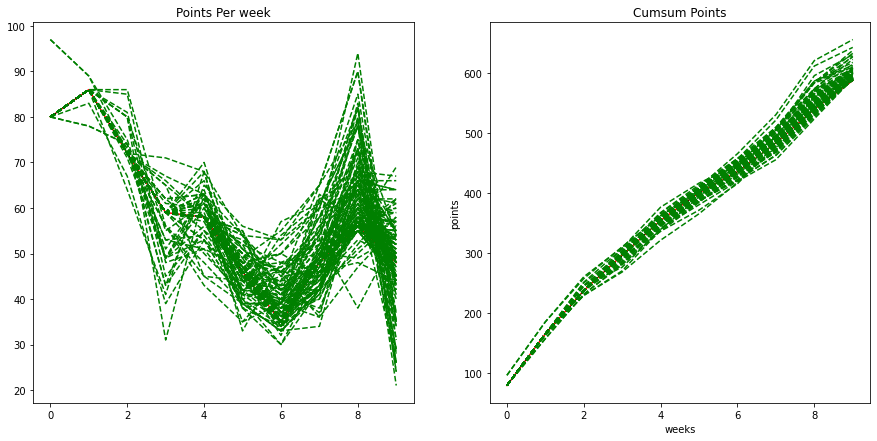

actually_better_plots : 167
[604.0, 602.0, 591.0, 603.0, 599.0, 593.0, 591.0, 600.0, 589.0, 591.0, 589.0, 591.0, 589.0, 593.0, 595.0, 602.0, 589.0, 590.0, 596.0, 589.0, 596.0, 594.0, 592.0, 597.0, 606.0, 591.0, 611.0, 613.0, 591.0, 638.0, 590.0, 589.0, 633.0, 590.0, 596.0, 592.0, 601.0, 596.0, 592.0, 592.0, 593.0, 593.0, 589.0, 643.0, 592.0, 593.0, 590.0, 595.0, 595.0, 593.0, 597.0, 592.0, 607.0, 594.0, 593.0, 589.0, 609.0, 589.0, 596.0, 593.0, 594.0, 589.0, 590.0, 589.0, 592.0, 589.0, 601.0, 589.0, 593.0, 589.0, 618.0, 592.0, 589.0, 591.0, 607.0, 604.0, 590.0, 589.0, 594.0, 591.0, 589.0, 656.0, 631.0, 601.0, 591.0, 596.0, 595.0, 627.0, 593.0, 590.0, 605.0, 615.0, 589.0, 598.0, 608.0, 592.0, 591.0, 594.0, 590.0, 591.0, 600.0, 589.0, 594.0, 592.0, 595.0, 589.0, 600.0, 589.0, 599.0, 590.0, 594.0, 595.0, 591.0, 605.0, 590.0, 590.0, 595.0, 592.0, 590.0, 600.0, 589.0, 600.0, 601.0, 602.0, 598.0, 591.0, 591.0, 595.0, 590.0, 598.0, 593.0, 592.0, 589.0, 594.0, 593.0, 589.0, 608.0, 591.0, 598.0

In [ ]:
# main code
fpl_manager_id = '2757'
current_week = 10
env = FPLSimulator(current_week, fpl_manager_id)

plot_pts = env.sample_visualization(10000)
print(plot_pts)

Sanity Check #2 : Checking to see if individual transfers are combined will they give you the same projections




(620,) (620, 10) (620, 10)
cumsum of per_week_total_points:  [ 80. 166. 238. 297. 355. 401. 436. 484. 540. 588.]
(15, 10) (15, 10) (15, 10)


100%|██████████| 10000/10000 [02:21<00:00, 70.62it/s]


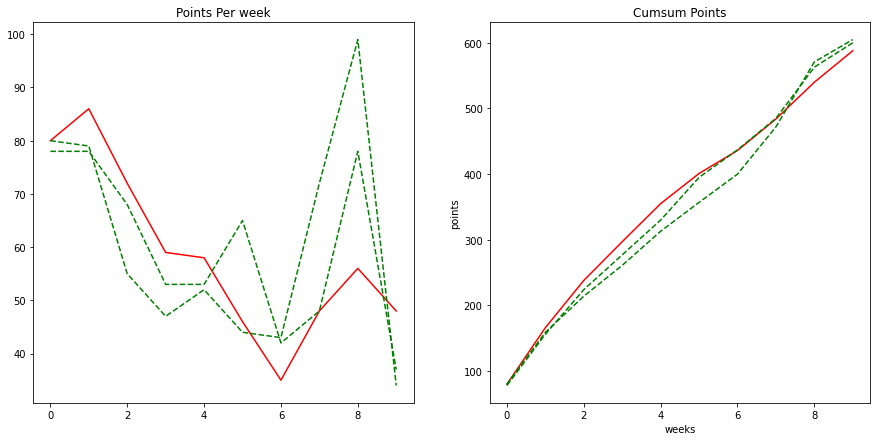

actually_better_plots : 2


100%|██████████| 10000/10000 [00:13<00:00, 714.40it/s]


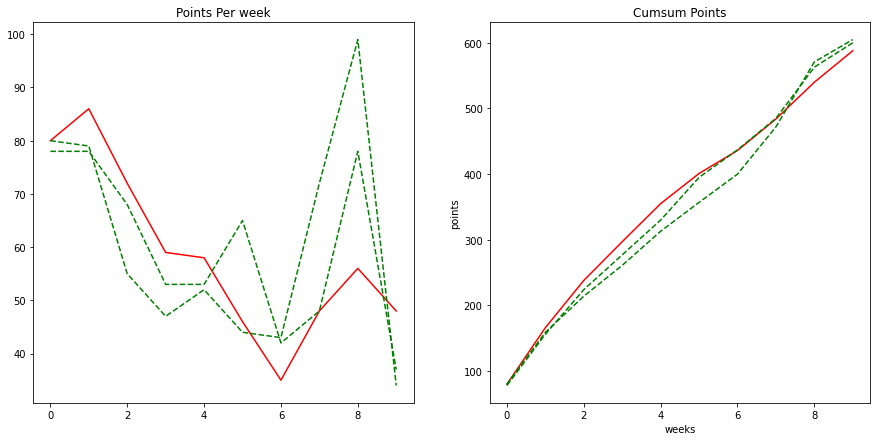

actually_better_plots : 2


True

In [ ]:

fpl_manager_id = '2757'
current_week = 10
env = FPLSimulator(current_week, fpl_manager_id)
# temp = np.array(env.actual_players_ids)
projs, pts1 = env.sample_visualization2_transfer_after_transfer(10000)
# temp1 = np.array(env.actual_players_ids)
plot_pts = env.sample_visualization(10000, projs)
# temp2 = np.array(env.actual_players_ids)
# assert(np.all(temp == temp1))

np.all(pts1 == plot_pts) # very important . dont remove this. 

In [ ]:

# print(pts1)
# print(plot_pts)

True

### Model Training


In [ ]:

%matplotlib inline
import math
import glob
import io
import base64
import time
from IPython.display import HTML
from IPython import display as ipythondisplay
from collections import namedtuple
from itertools import count

# Colab comes with PyTorch
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F

import copy

"""
define your network here
"""
class RecruiterNetwork(nn.Module):

  def __init__(self, n_state_vector, n_action_space):
    super(RecruiterNetwork, self).__init__()
    self.layer = nn.Sequential(
        # nn.BatchNorm1d(n_state_vector + n_action_space),
        nn.Linear(n_state_vector + n_action_space, 30),
        nn.ReLU(inplace=True),
        #TODO: change this back
        # nn.BatchNorm1d(30),
        nn.Linear(30,30),
        nn.ReLU(inplace=True),

        # nn.BatchNorm1d(30),
        nn.Linear(30,30),
        nn.ReLU(inplace=True),

        # nn.BatchNorm1d(30),
        nn.Linear(30,1),
        # nn.ReLU(inplace=True)
    )

  def forward(self,x):
    out = self.layer(x)
    return out

In [ ]:


def epsilon_greedy_action(env, state, model, epsilon, t):

  state = np.array(state) # (N_states,)
  assert(state.ndim == 1)
  # bp()
  week_vector = np.zeros(current_week)
  week_vector[t] = 1.0
  state = np.append(state, week_vector)
  # we are gonna evaluate over all the different set of actions
  input = np.hstack((np.broadcast_to(state,(possible_actions.shape[0], state.shape[0])), possible_actions)) # (N_A,N_S+N_A)
  assert(input.shape == (N_actions, N_actions + N_states + current_week)) # we are adding in the week vector too for now
  X = torch.from_numpy(input).float().cuda()
  model.eval()
  Y = model(X)
  assert(Y.shape == (N_actions,1))
  Y = Y.detach().cpu().numpy()
  best_idx = np.argmax(Y.reshape(-1))

  # you dont get to choose the best action. have soft probabilities based on exploration epsilon
  selection_prob_arr = np.zeros(N_actions,dtype=np.float)
  selection_prob_arr[:] = epsilon / N_actions
  selection_prob_arr[best_idx] = (epsilon / N_actions) + (1 - epsilon)
  # bp()
  assert(selection_prob_arr.sum().round() == 1.0)
  idx = np.random.choice(N_actions,1,replace=False, p = selection_prob_arr)
  # assert(idx.shape == (1,))
  model.train()
  # bp()
  # env.action_space.sample()
  return possible_actions[idx], idx[0]

def calculate_episode_return(episode, gamma):
  episode = np.array(episode)
  assert(episode.ndim == N_actions)
  states_array = episode[:,0]
  # actions_array = episode[:,1]
  rewards_array = episode[:,2]
  # gamma_array = [gamma**i for i in range(episode.shape[0])]
  # Gt = rt + gamma * Gt\+1.
  # bp()
  G = np.array([0 for i in range(states_array.shape[0])], dtype = np.float)
  for i in range(G.shape[0]-1,-1,-1):
    # temp = G[i+1]
    if i == G.shape[0] - 1:
      temp = 0
    else:
      temp = G[i+1]
    G[i] = rewards_array[i] + gamma * temp
  # bp()
  assert(G[-1] == 1.0)
  return G


def update_Q_value(G, episode, model, optimizer):
  episode = np.array(episode)
  model = model.cuda()
  model.train()
  optimizer.zero_grad()
  loss_criterion = nn.MSELoss()
  # loss_criterion = nn.L1Loss() #TODO : maybe change this back
  # bp()
  action_arr = possible_actions[np.array(episode[:,1], np.int),:] #(num_weeks,N_actions)
  state_arr = np.array([i.tolist() for i in episode[:,0]], np.float) #(num_weeks,N_states)

  assert(state_arr.shape[0] == action_arr.shape[0])
  week_vector = np.eye(current_week) # (num_weeks,num_weeks)
  state_arr = np.hstack((state_arr, week_vector)) # (num_weeks, N_states + num_weeks)
  X = torch.from_numpy(np.hstack((state_arr, action_arr))).cuda().float() #(num_weeks, N_states + num_weeks + N_actions) 
  Y = torch.from_numpy(G[:,np.newaxis]).float().cuda() # (B,1)
  # old_mean = Y.mean()
  # old_std = Y.std()
  # Y = (Y - old_mean) / old_std 
  # bp()
  output = model(X)
  # print('output {}, Y {}'.format(output.mean(),Y.mean()))
  assert(output.shape == Y.shape)
  loss = loss_criterion(output,Y)
  loss.backward()
  optimizer.step()
  assert(loss.grad_fn != None)
  model.eval()
  return loss.detach().cpu().numpy(), output.detach().cpu().numpy(), Y.detach().cpu().numpy()

In [ ]:
"""
Training the model for MC Control for FPL environment
"""
# % rm /content/video/*.*

print('Training the model for MC Control for FPL environment')

save_path = './models/'
if not os.path.exists(save_path):
  os.makedirs(save_path)
print('save path :{}'.format(save_path))

np.random.seed(11)
random.seed(11)
torch.manual_seed(11)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(11)
torch.cuda.manual_seed_all(11)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.device(DEVICE)

epsilon = 0.1
epsilon_decay = 0.99
epsilon_min = 0.1
gamma = 1.0
# possible_actions = np.array([[1,0,0,0,0],[0,1]]) # left or right discretized (2,2)
N_actions = 5
N_states = 10

possible_actions = np.eye(N_actions)


# -----------------------------------------------
# TODO : try adjusting these params
n_episode = 3000     # number of episodes
max_steps = 1000  # maximum steps for each episode
lr = 1e-3
epsilon_iter_delta = 200 # this needs to be high . need more exploration 

network = RecruiterNetwork(N_states + current_week, N_actions)
network = network.cuda()
optimizer = optim.Adam(network.parameters(), lr=lr)
network.train()


fpl_manager_id = '2757'
current_week = 10
env = FPLSimulator(current_week, fpl_manager_id)

for i_episode in range(n_episode):
  observation = env.reset() # get the state
  episode = []
  G_all = []

  if i_episode % epsilon_iter_delta == 0:
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

  # this creates 'W' different transfers, like one every week
  # method of training : 1. have a 
  for t in range(current_week):
    s = observation
    a, action_idx = epsilon_greedy_action(env, s, network, epsilon, t)
    observation, r, done = env.step(a, t)
    # s_prime = observation
    episode.append([s,action_idx,r])

    if done:
      break
  G_all = calculate_episode_return(episode,gamma)
  loss,out,gt = update_Q_value(G_all, episode, network, optimizer)
  break

Training the model for MC Control for FPL environment
save path :./models/


KeyboardInterrupt: ignored